# Model Training notebook

Contains the whole pipeline to train the models.  
How to use:   

Run the first cells to import all needed models and functions  
Then run the cell that loads the weights, if none are present it will create a new model  
Run the training cell and adjust N and iterations accordingly. Using a higher N will use more RAM, so you can lower N and augment iterations.  
Finally if the results are are good, you can save the model weigths. Only do it if the results are nice, because it overwrites the old weigths. 
The last cell vizualizes 3 different reference images with very different D values. 

In [1]:
# Hyperparameters for simulation
nparticles = 1000   # Number of particles
nframes = 16    # Number of steps in the simulation
nposframe = 10    # Number of position per frame
dt = 0.01        # Integration time frame in second (time between two frames)
DGen = 20000        # Diffusion coefficient in nm^2 per s (=0.000001 (um^2)/s)
num_steps = nframes*nposframe
# Hyperparameters for image generation
npixel = 64 # number of image pixels
pixelsize = 100 # in nm 
fwhm_psf = 200 # full width half maximum (emulates microscope)
factor_hr = 5 # image high resulution factor
flux = 100 # number of photons per s
poisson_noise = 100 
gaussian_noise = 10
background = 100 # base background value
normalizeValue = 1000 # value by which all samples will be normalized ! Needs to be fixed and the same for all images !
n_val_im = 50


In [2]:
%reload_ext autoreload
%autoreload 2
from helpers import *
from modelsUtils import *
from simpleCNNModel import *
from ResNetModel2D import *
from ResNetModel3D import *
from paperCNN import *
from paperCNNNoPooling import *
import os.path

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


c:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Using device: cpu


In [3]:
# Models used in a dictionnary comprehension. 
# To add  anew model, simply add it to the list with the wanted train fct

lr = 0.000001
models_params = {
    #"simpleCNN": {"class": SimpleCNN, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "resNet2D": {"class": ResNet2D, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "resNet3D": {"class": ResNet3D, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "paperCNNAdam": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "paperCNNSGD": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "sgd", "lr" :lr},
    "paperCNNNoPool": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" :lr}
    
}

In [4]:
for name, params in models_params.items():
    class_ = params["class"]
    # Load the model weights
    loaded_model = class_().to(device)
    filename = "w_" + name + ".pth"
    if os.path.exists(filename):
        loaded_model = load_model_weights(loaded_model, filename)
        print(name, "Loaded existing weights")
    else:
        print(name, "Did not find weights, loaded a new model")
        
    params["loaded_model"] = loaded_model  # Update the dictionary with the loaded model
    
    if(isinstance(params["optimizer"],str)):
        if params["optimizer"] == "adam":
            params["optimizer"] = optim.Adam(loaded_model.parameters(), lr=params["lr"])
        elif params["optimizer"] == "sgd":
            params["optimizer"] = optim.SGD(loaded_model.parameters(), lr=params["lr"], momentum=0.9)
        else: 
            params["optimizer"] = optim.Adam(loaded_model.parameters(), lr=params["lr"])

Model weights loaded from w_resNet2D.pth
resNet2D Loaded existing weights
Model weights loaded from w_resNet3D.pth
resNet3D Loaded existing weights
Model weights loaded from w_paperCNNAdam.pth
paperCNNAdam Loaded existing weights
Model weights loaded from w_paperCNNSGD.pth
paperCNNSGD Loaded existing weights
Model weights loaded from w_paperCNNNoPool.pth
paperCNNNoPool Loaded existing weights


In [8]:
import os
import numpy as np
from PIL import Image

# Path to the folder containing the images
folder_path = "real-data/blocks_64x64x16_70_01"

# Get a list of all files in the folder
file_list = sorted(os.listdir(folder_path))  # Sorted lexicographically

# Filter only files with valid image extensions and specific naming pattern
valid_extensions = (".tif")
image_files = [f for f in file_list if f.endswith(valid_extensions) and f.startswith("block-001")]

# Initialize an empty list for predictions
predictions = []

params = models_params["resNet2D"]

# Process each .tif file
for file in image_files:
    image_path = os.path.join(folder_path, file)
    
    # Open the .tif file and load all 16 frames
    with Image.open(image_path) as img:
        frames = []
        for i in range(16):  # Assuming each .tif file has exactly 16 frames
            img.seek(i)  # Access frame i
            frame_array = np.array(img) / 500  # Normalize by 18000
            frames.append(frame_array)
    
    # Convert frames to a NumPy array of shape (16, 64, 64)
    val_images = np.stack(frames, axis=0)
    
    # Query the model for predictions
    model = params["loaded_model"]
    model_preds = predict_diffusion_coefficients(model, val_images, device)
    predictions.append(model_preds)

# Convert predictions to a NumPy array for further processing or saving
predictions = np.array(predictions)

# Print shape of predictions for verification
print("Predictions shape:", predictions.shape)
print(predictions)
# Save predictions if needed
# np.save("predictions.npy", predictions)


Predictions shape: (53,)
[-4688.9097 -4908.816  -4627.5923 -4641.7896 -4712.999  -4650.894
 -5131.719  -4713.178  -4658.9004 -4723.0386 -4641.402  -4719.981
 -4673.1562 -4731.4985 -4791.268  -5092.5537 -4529.9253 -4801.957
 -4862.4546 -4760.319  -4649.386  -5077.4243 -4810.59   -4740.31
 -5121.8906 -4632.001  -4690.817  -4670.1772 -4679.3833 -5196.336
 -4718.578  -5095.555  -4671.267  -4557.0186 -5141.7363 -4763.858
 -4629.859  -4816.0747 -4801.416  -5035.189  -4710.997  -4721.0293
 -4636.03   -4612.3423 -5151.9766 -4736.6113 -5109.6265 -4732.649
 -4671.5845 -5026.9595 -4816.2285 -4584.2256 -4924.275 ]


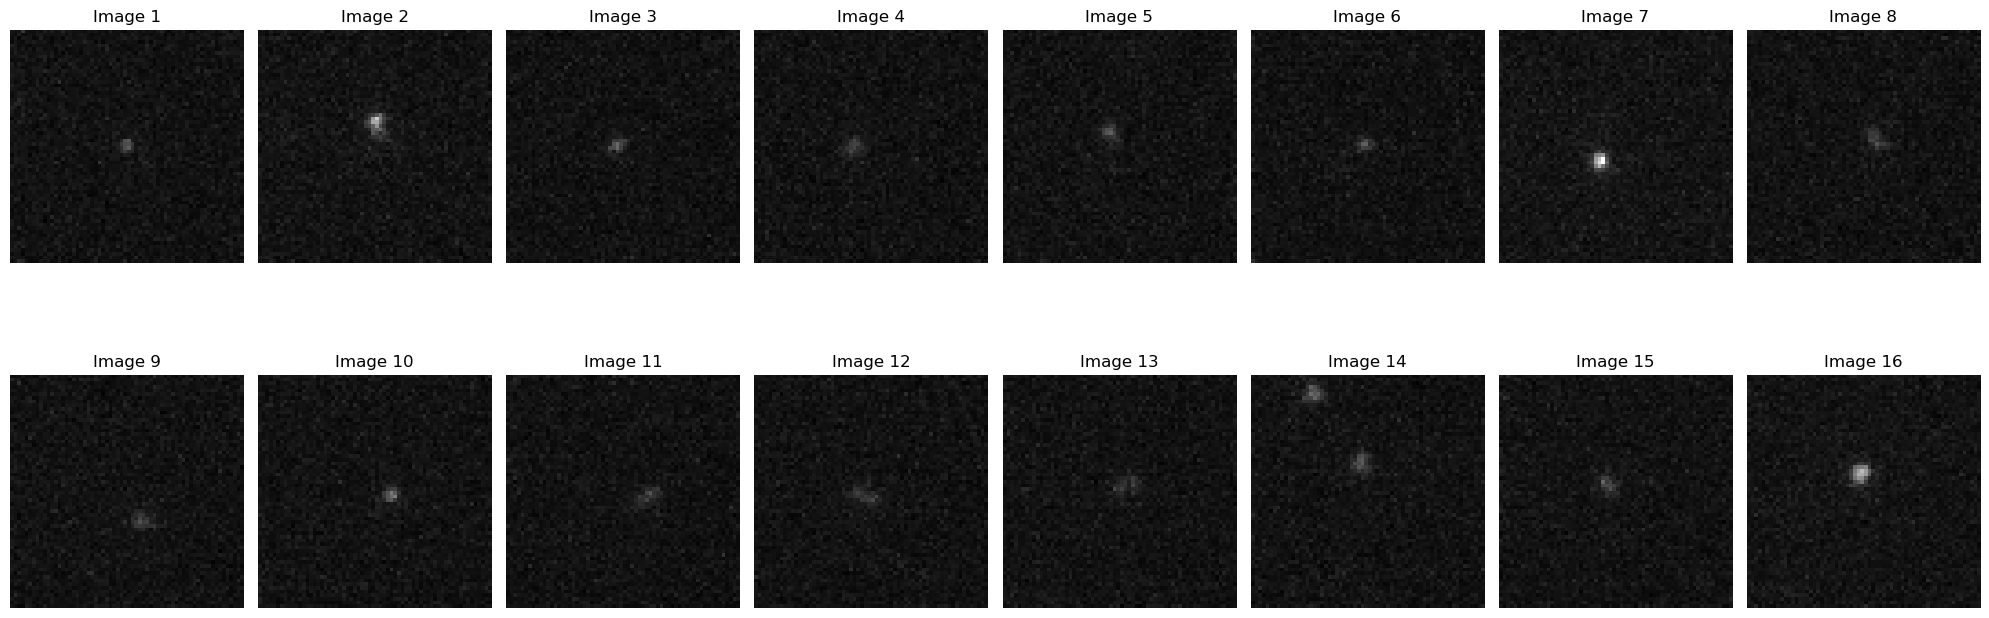

Global Min Intensity: 500, Global Max Intensity: 12410


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Path to the folder containing the images
folder_path = "real-data/blocks_64x64x16_70_01"

# Get a list of all files in the folder
file_list = sorted(os.listdir(folder_path))  # Sorted lexicographically

# Filter only files with valid image extensions (e.g., .tif, .jpg, .png)
valid_extensions = (".tif")
image_files = [f for f in file_list if f.endswith(valid_extensions) and f.startswith("block-001")]

# Read all images and determine global min and max intensity
images = []
global_min = float("inf")
global_max = float("-inf")

for file in image_files:

    image_path = os.path.join(folder_path, file)
    image = Image.open(image_path)
    image_array = np.array(image)
    images.append(image_array)
    global_min = min(global_min, image_array.min())
    global_max = max(global_max, image_array.max())

# Display up to 16 images in 2 rows of 8 images each, on the same scale
num_images = min(16, len(images))  # Ensure we don't exceed 16 images
rows, cols = 2, 8  # 2 rows, 8 images per row
plt.figure(figsize=(20, 8))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i] , cmap="gray", vmin=global_min, vmax=global_max)
    plt.title(f"Image {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

print(f"Global Min Intensity: {global_min}, Global Max Intensity: {global_max}")


Generating trajectories: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


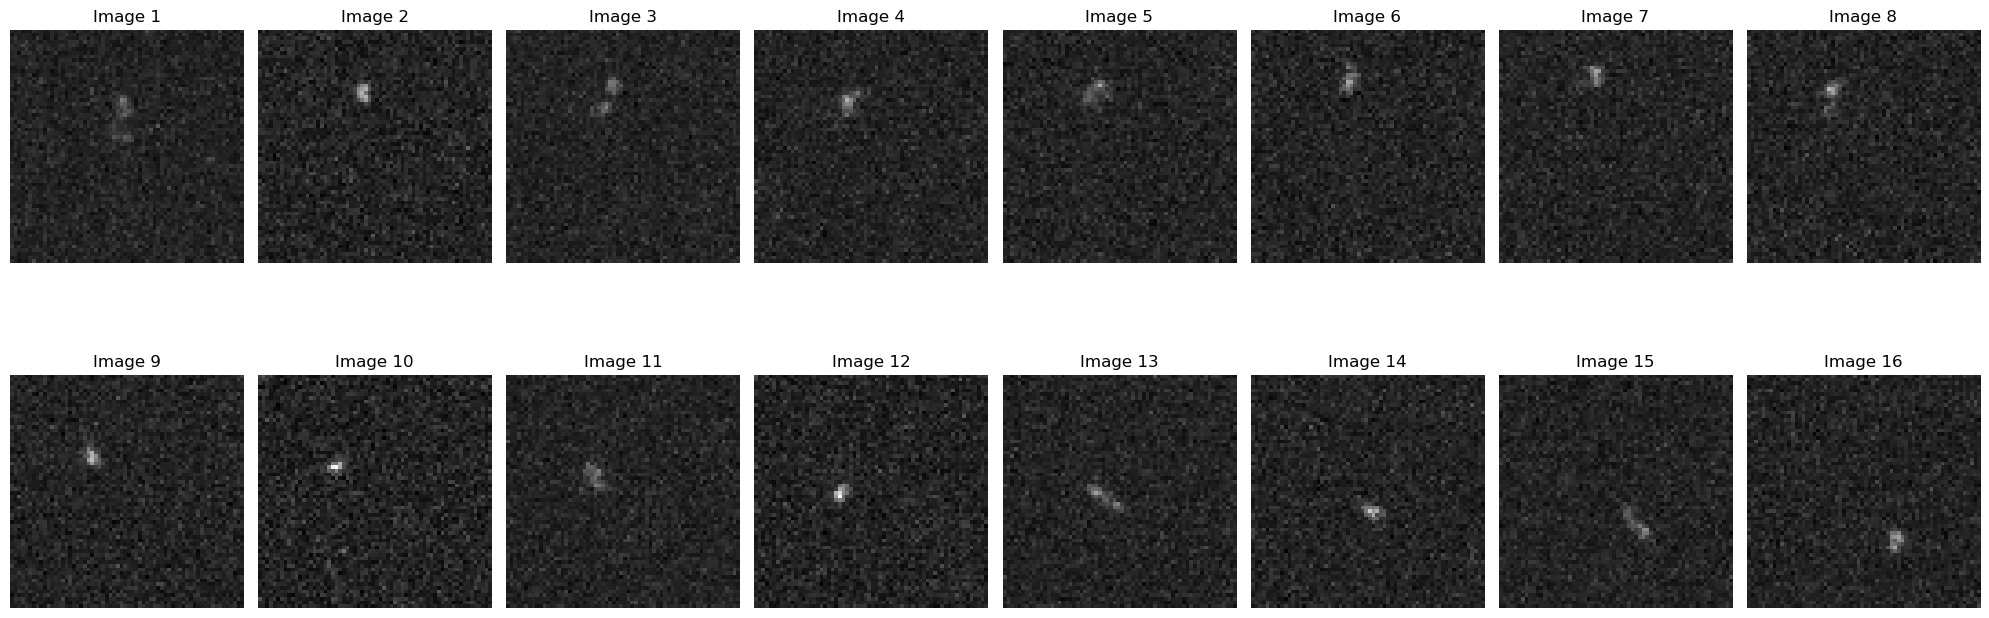

Global Min Intensity: 0.0, Global Max Intensity: 0.7060546875


In [9]:
global_min_gen = float("inf")
global_max_gen = float("-inf")

images_arr, estimatedDs =  generateImagesAndEstimateDMAXD(1, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
images = images_arr[0]

global_min_gen = np.min(images)
global_max_gen = np.max(images)

# Display up to 16 images in 2 rows of 8 images each, on the same scale
num_images = min(16, len(images))  # Ensure we don't exceed 16 images
rows, cols = 2, 8  # 2 rows, 8 images per row
plt.figure(figsize=(20, 8))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i], cmap="gray", vmin=global_min_gen, vmax=global_max_gen)
    plt.title(f"Image {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

print(f"Global Min Intensity: {global_min_gen}, Global Max Intensity: {global_max_gen}")